# *Configuration*

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# For Oversampling
!pip install imbalanced-learn

In [3]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# *Data Loading & First Preprocessing & Learn/Predict/Evaluate*

In [4]:
card_df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
card_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
# Time -> Drop 
# Class 0 -> 정상, 1 -> Fraud
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [7]:
def get_train_test_dataset(df=None) :
    df_copy = get_preprocessed_df(df)
    x_features = df_copy.iloc[:, :-1]
    y_labels = df_copy.iloc[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.3, stratify=y_labels)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

In [8]:
print(y_train.value_counts() / y_train.shape[0] * 100)
print(y_test.value_counts() / y_test.shape[0] * 100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, f1-score: {3: .4f}'.format(accuracy, precision, recall, f1))

lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)
get_clf_eval(y_test, lr_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion Matrix
[[85267    28]
 [   62    86]]
Accuracy: 0.9989, Precision: 0.7544, Recall: 0.5811, f1-score:  0.6565


In [10]:
# 인자로 Estimator 객체와 학습/테스트 데이터 셋을 입력 받아 학습/평가를 진행함.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None) :
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

In [11]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, tree_method='gpu_exact')
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

Confusion Matrix
[[85287     8]
 [   33   115]]
Accuracy: 0.9995, Precision: 0.9350, Recall: 0.7770, f1-score:  0.8487


# *Model Training/Prediction/Evaluation after data distribution transformation*

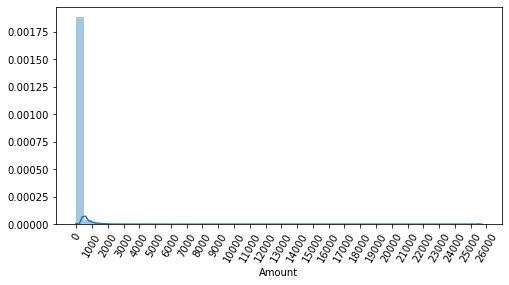

In [12]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

### *StandardScaler*

In [13]:
# Amount 값을 표준 졍규 분포로 변환시켜준다.
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [14]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

In [15]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, tree_method='gpu_exact')
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

Confusion Matrix
[[85282    13]
 [   58    90]]
Accuracy: 0.9992, Precision: 0.8738, Recall: 0.6081, f1-score:  0.7171
Confusion Matrix
[[85292     3]
 [   34   114]]
Accuracy: 0.9996, Precision: 0.9744, Recall: 0.7703, f1-score:  0.8604


### *log1p*

In [16]:
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [17]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, tree_method='gpu_exact', verbose=1)
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

Confusion Matrix
[[85283    12]
 [   57    91]]
Accuracy: 0.9992, Precision: 0.8835, Recall: 0.6149, f1-score:  0.7251
Confusion Matrix
[[85289     6]
 [   30   118]]
Accuracy: 0.9996, Precision: 0.9516, Recall: 0.7973, f1-score:  0.8676


# *Model Training/Prediction/Evaluation after removing outlier data*

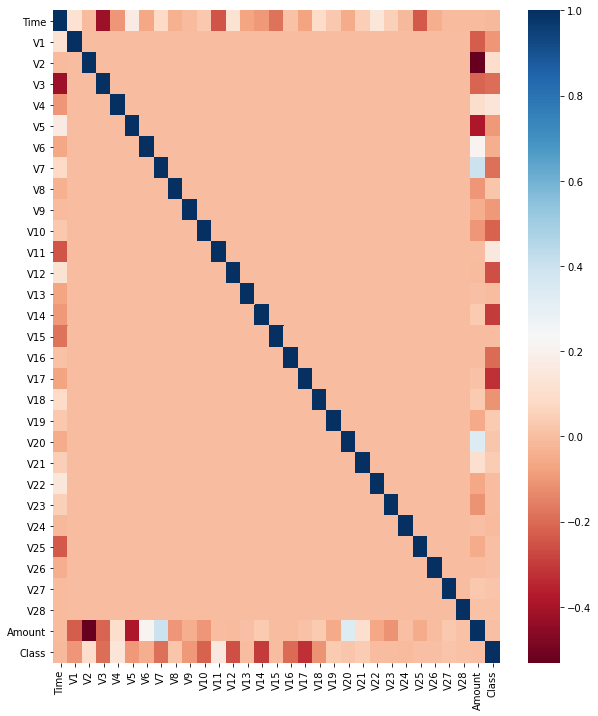

In [18]:
plt.figure(figsize=(10, 12))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [19]:
def get_outlier(df=None, column=None, weight=1.5) :
    fraud = df[df.Class == 1][column]
    q_25 = np.percentile(fraud.values, 25)
    q_75 = np.percentile(fraud.values, 75)
    
    iqr = q_75 - q_25
    iqr_weight = iqr * weight
    lowest_val = q_25 - iqr_weight
    highest_val = q_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [20]:
outlier_index = get_outlier(card_df, 'V14')
print(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [21]:
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(card_df, 'V14')
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [22]:
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, tree_method='gpu_exact', verbose=1)
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

Confusion Matrix
[[85284    11]
 [   67    79]]
Accuracy: 0.9991, Precision: 0.8778, Recall: 0.5411, f1-score:  0.6695
Confusion Matrix
[[85289     6]
 [   38   108]]
Accuracy: 0.9995, Precision: 0.9474, Recall: 0.7397, f1-score:  0.8308


# *Model Training/Prediction/Evaluation after SMOTE Oversampling*

In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_train_over, y_train_over = smote.fit_sample(x_train, y_train)
print(y_train.value_counts())
print(pd.Series(y_train_over).value_counts())

0    199020
1       342
Name: Class, dtype: int64
1    199020
0    199020
Name: Class, dtype: int64


In [24]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train_over, x_test, y_train_over, y_test)

Confusion Matrix
[[83579  1716]
 [   23   123]]
Accuracy: 0.9796, Precision: 0.0669, Recall: 0.8425, f1-score:  0.1239


In [25]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.legend()
    plt.grid()
    plt.show()

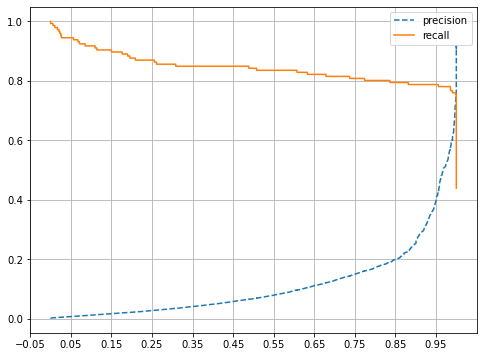

In [26]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(x_test)[:, 1])

In [27]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False, tree_method='gpu_exact', verbose=1)
get_model_train_eval(lgbm_clf, x_train_over, x_test, y_train_over, y_test)

Confusion Matrix
[[85281    14]
 [   32   114]]
Accuracy: 0.9995, Precision: 0.8906, Recall: 0.7808, f1-score:  0.8321
